In [79]:
import pandas as pd
import numpy as np
import re
import xarray as xr
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings('ignore') #headache management
import os
import matplotlib.pyplot as plt
import seaborn as sns


#basic count rows

df = pd.read_csv("Shark%2C_Skate_or_Ray_Species_Distribution.csv")
spec_dist_clean = df.replace(r'^\s*$', np. nan, regex=True).dropna(how='all')

ray_columns = ['cntBlondeRay', 'cntCuckooRay', 'cntElectricRay', 'cntHomelynRay',
               'cntPaintedRay', 'cntSandyRay', 'cntStingray', 'cntThornbackRay', 'cntUndulateRay']
shark_columns = ['cntAngelshark', 'cntBlackmouthedDogfish', 'cntBlueShark', 'cntBullHuss',
                 'cntLesserSpottedDogfish', 'cntMakoShark', 'cntPorbeagleShark',
                 'cntSixGilledShark', 'cntSmoothHound', 'cntSpurdog', 'cntThresherShark', 'cntTope']

spec_dist_clean['Total_Rays'] = df[ray_columns].sum(axis=1)
spec_dist_clean['Total_Sharks'] = df[shark_columns].sum(axis=1)
spec_dist_clean = spec_dist_clean.rename(columns={'cntCommonSkateSpeciesComplex': 'Total_Skates'})



In [80]:
#ICES code conversion to latitude/longitude centroids

LAT0, LON0 = 36.0, -44.0
COL_LETTERS = [chr(x) for x in range(ord('A'), ord('M')+1) if chr(x) != 'I']

def ices_centroid_from_code(code):
    if not isinstance(code, str) or len(code) < 4:
        return (None, None)
    code = code.strip(). upper()
    m = re.match(r'^(\d{2})([A-Z])(\d)$', code[:4])
    if not m:
        return (None, None)
    row, col_letter, col_digit = int(m.group(1)), m.group(2), int(m.group(3))
    if col_letter not in COL_LETTERS:
        return (None, None)
    lat_cent = LAT0 + (row - 1) * 0.5 + 0.25
    lon_cent = LON0 + (COL_LETTERS.index(col_letter) * 10 + col_digit) + 0.5
    return (round(lat_cent, 6), round(lon_cent, 6))

def add_ices_centroids_df(df, ices_col='ICESNAME', sub_col='sub_code'):
    df = df.copy()
    def pick_code(row):
        s = row. get(sub_col, '')
        if isinstance(s, str) and s. strip():
            return s.strip()
        return row. get(ices_col, '').strip() if row.get(ices_col) is not None else ''
    codes = df. apply(pick_code, axis=1)
    coords = codes.map(lambda c: ices_centroid_from_code(c) if c else (None, None))
    df['centroid_lat'] = coords. map(lambda x: x[0])
    df['centroid_lon'] = coords.map(lambda x: x[1])
    return df

def get_ices_sea_area(lat, lon):
    if pd.isna(lat) or pd.isna(lon):
        return (None, None)
    if 53.5 <= lat <= 66 and 9 <= lon <= 30:
        return ('IIIa', 'Skagerrak and Kattegat') if lat >= 57.5 and lon <= 12 else ('IIId', 'Baltic Sea')
    if lat >= 62 and -4 <= lon <= 20:
        return ('IIa', 'Norwegian Sea')
    if 51 <= lat <= 62 and -4 <= lon <= 9:
        if lat >= 57.5:
            return ('IVa', 'Northern North Sea')
        elif lat >= 53.5:
            return ('IVb', 'Central North Sea')
        return ('IVc', 'Southern North Sea')
    if 48 <= lat <= 56 and -18 <= lon <= 0:
        return ('VII', 'Celtic Seas')
    return ('Unknown', 'Unknown Area')

spec_dist_with_centroids = add_ices_centroids_df(spec_dist_clean)
spec_dist_with_centroids['division_code'], spec_dist_with_centroids['sea_area'] = zip(
    *spec_dist_with_centroids. apply(lambda row: get_ices_sea_area(row['centroid_lat'], row['centroid_lon']), axis=1))

spec_dist_final = spec_dist_with_centroids.drop(columns=['ICESNAME', 'sub_code', 'Shape__Area', 'Shape__Length', 'division_code'])

print(f"Preprocessed {len(spec_dist_final)} records")
print(spec_dist_final[['sea_area', 'centroid_lat', 'centroid_lon', 'Total_Sharks', 'Total_Rays']].head())

Preprocessed 503 records
             sea_area  centroid_lat  centroid_lon  Total_Sharks  Total_Rays
0         Celtic Seas         51.75          -4.5             7           1
1         Celtic Seas         51.75          -4.5           103          36
2         Celtic Seas         51.75          -4.5             0           8
3  Southern North Sea         51.25          -3.5            16          11
4  Southern North Sea         52.25          -3.5            11           3


In [81]:
#Data Extraction from .nc files

print("Extracting environmental data...")

df = spec_dist_final.copy()

#.nc file manipulation

def extract_environmental_data(df, nc_file, var_name, output_col):
    if not os.path. exists(nc_file):
        print(f"File not found: {nc_file}")
        df[output_col] = None
        return df

    try:
        ds = xr.open_dataset(nc_file)

        if isinstance(var_name, str):
            var_name = [var_name]

        found_var = next((v for v in var_name if v in ds.data_vars), None)
        if not found_var:
            df[output_col] = None
            ds.close()
            return df

        lat_coord = next((c for c in ['lat', 'latitude', 'y'] if c in ds.coords), None)
        lon_coord = next((c for c in ['lon', 'longitude', 'x'] if c in ds.coords), None)
        time_coord = next((c for c in ['time', 't'] if c in ds.coords), None)
        depth_coord = next((c for c in ['depth', 'lev', 'z'] if c in ds.coords), None)

        if not lat_coord or not lon_coord:
            df[output_col] = None
            ds.close()
            return df

        values = []
        valid_count = 0

        for idx, row in df.iterrows():
            lat = row['centroid_lat']
            lon = row['centroid_lon']

            if pd.notna(lat) and pd.notna(lon):
                try:
                    point = ds[found_var].sel({lat_coord: lat, lon_coord: lon}, method='nearest')

                    if time_coord and time_coord in point.dims:
                        point = point.mean(dim=time_coord)

                    if depth_coord and depth_coord in point.dims:
                        point = point.isel({depth_coord: -1})

                    val = float(point. values)

                    if not (np.isnan(val) or np.isinf(val) or val < -9999):
                        values.append(val)
                        valid_count += 1
                    else:
                        values.append(None)

                except:
                    values.append(None)
            else:
                values.append(None)

        df[output_col] = values
        ds.close()

        print(f"{output_col}: {valid_count}/{len(df)} valid values ({valid_count/len(df)*100:.1f}%)")

        return df

    except Exception as e:
        print(f"Error processing {nc_file}: {e}")
        df[output_col] = None
        return df

#Was orignially going to use copernicus' toolbox api to do this, but after 2 hours of fuckery i decided to just do it manually. saves on
#time as well

Extracting environmental data...


In [82]:
#Adding to the csv

df = extract_environmental_data(df, 'TEMP.nc', ['bottomT', 'thetao', 'temperature', 'temp'], 'bottom_temp_C')
df = extract_environmental_data(df, 'SALINE.nc', ['so', 'salinity', 'sal'], 'salinity_psu')
df = extract_environmental_data(df, 'DEPTH.nc', ['mlotst', 'mld', 'mixed_layer_depth', 'depth'], 'mixed_layer_depth_m')

output_file = 'species_distribution_complete.csv'
df.to_csv(output_file, index=False)

print(f"\nSaved to: {output_file}")

display_cols = ['sea_area', 'centroid_lat', 'centroid_lon', 'Total_Sharks', 'Total_Rays', 'bottom_temp_C', 'salinity_psu', 'mixed_layer_depth_m']
display_cols = [c for c in display_cols if c in df.columns]
print(f"\nSample data:")
print(df[display_cols].head(10). to_string(index=False))

bottom_temp_C: 209/503 valid values (41.6%)
salinity_psu: 210/503 valid values (41.7%)
mixed_layer_depth_m: 209/503 valid values (41.6%)

Saved to: species_distribution_complete.csv

Sample data:
          sea_area  centroid_lat  centroid_lon  Total_Sharks  Total_Rays  bottom_temp_C  salinity_psu  mixed_layer_depth_m
       Celtic Seas         51.75          -4.5             7           1      12.129351           NaN             8.179250
       Celtic Seas         51.75          -4.5           103          36      12.129351           NaN             8.179250
       Celtic Seas         51.75          -4.5             0           8      12.129351           NaN             8.179250
Southern North Sea         51.25          -3.5            16          11      11.981808     32.705173            23.365757
Southern North Sea         52.25          -3.5            11           3            NaN           NaN                  NaN
Southern North Sea         51.25          -2.5           674      

In [83]:



df = pd.read_csv('species_distribution_complete.csv')
print(f"Initial dataset: {df.shape}")

env_cols = ['bottom_temp_C', 'salinity_psu', 'mixed_layer_depth_m']

#spatial median imputation

for col in env_cols:
    missing_count = df[col].isna(). sum()
    print(f"{col}: {missing_count} missing ({missing_count/len(df)*100:.1f}%)")

def spatial_median_imputation(df, col, lat_col='centroid_lat', lon_col='centroid_lon', k=2):
    missing_mask = df[col].isna()
    missing_indices = df[missing_mask].index
    imputed_count = 0

    for idx in missing_indices:
        target_lat = df.loc[idx, lat_col]
        target_lon = df.loc[idx, lon_col]
        valid_data = df[df[col].notna()].copy()

        if len(valid_data) == 0:
            continue

        valid_data['distance'] = np.sqrt(
            (valid_data[lat_col] - target_lat)**2 +
            (valid_data[lon_col] - target_lon)**2
        )

        nearest = valid_data.nsmallest(k*2, 'distance')

        if len(nearest) > 0:
            median_value = nearest[col].median()
            df.loc[idx, col] = median_value
            imputed_count += 1

    return df, imputed_count

for col in env_cols:
    df, imputed = spatial_median_imputation(df, col, k=2)
    remaining_missing = df[col].isna().sum()
    print(f"{col}: Imputed {imputed} values, {remaining_missing} remaining")

df_with_env = df.dropna(subset=env_cols)
print(f"\nComplete cases: {len(df_with_env)}/{len(df)} ({len(df_with_env)/len(df)*100:.1f}%)")


Initial dataset: (503, 33)
bottom_temp_C: 294 missing (58.4%)
salinity_psu: 293 missing (58.3%)
mixed_layer_depth_m: 294 missing (58.4%)
bottom_temp_C: Imputed 294 values, 0 remaining
salinity_psu: Imputed 293 values, 0 remaining
mixed_layer_depth_m: Imputed 294 values, 0 remaining

Complete cases: 503/503 (100.0%)


In [84]:
#edge cases

def detect_outliers_iqr(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col]. quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = ((df[col] < lower_bound) | (df[col] > upper_bound))
    return outliers, lower_bound, upper_bound

outlier_summary = {}

for col in env_cols + ['Total_Sharks', 'Total_Rays', 'Total_Skates']:
    if col in df_with_env. columns:
        outliers, lower, upper = detect_outliers_iqr(df_with_env, col)
        n_outliers = outliers.sum()
        outlier_summary[col] = n_outliers
        print(f"{col}: {n_outliers} outliers ({n_outliers/len(df_with_env)*100:.1f}%)")

quality_checks = {
    'Temperature': df_with_env['bottom_temp_C'].between(-2, 30). all(),
    'Salinity': df_with_env['salinity_psu'].between(0, 40).all(),
    'Depth': df_with_env['mixed_layer_depth_m'].between(0, 500).all(),
    'Counts': (df_with_env['Total_Sharks'] >= 0).all() and (df_with_env['Total_Rays'] >= 0). all() and (df_with_env['Total_Skates'] >= 0).all()
}

for check, passed in quality_checks.items():
    status = "PASS" if passed else "FAIL"
    print(f"[{status}] {check}")

df_clean = df_with_env.copy()

bottom_temp_C: 26 outliers (5.2%)
salinity_psu: 1 outliers (0.2%)
mixed_layer_depth_m: 97 outliers (19.3%)
Total_Sharks: 81 outliers (16.1%)
Total_Rays: 87 outliers (17.3%)
Total_Skates: 108 outliers (21.5%)
[PASS] Temperature
[PASS] Salinity
[PASS] Depth
[PASS] Counts


In [85]:
#correlation matrixes + variance

feature_cols = ['bottom_temp_C', 'salinity_psu', 'mixed_layer_depth_m',
                'centroid_lat', 'centroid_lon', 'Decade']
target_cols = ['Total_Sharks', 'Total_Rays', 'Total_Skates']

X = df_clean[feature_cols]. copy()
y_sharks = df_clean['Total_Sharks']
y_rays = df_clean['Total_Rays']
y_skates = df_clean['Total_Skates']

correlation_matrix = df_clean[env_cols + target_cols].corr()
print("\nCorrelations with Total_Sharks:")
print(correlation_matrix['Total_Sharks'].sort_values(ascending=False))
print("\nCorrelations with Total_Rays:")
print(correlation_matrix['Total_Rays'].sort_values(ascending=False))
print("\nCorrelations with Total_Skates:")
print(correlation_matrix['Total_Skates'].sort_values(ascending=False))

X_env = df_clean[env_cols].copy()
vif_data = pd.DataFrame()
vif_data["Feature"] = X_env.columns
vif_data["VIF"] = [variance_inflation_factor(X_env. values, i) for i in range(len(X_env.columns))]
print("\nMulticollinearity (VIF > 10 indicates high):")
print(vif_data)

scaler_pca = StandardScaler()
X_scaled_pca = scaler_pca.fit_transform(X_env)

pca = PCA()
pca.fit(X_scaled_pca)

print(f"\nPCA explained variance: {pca.explained_variance_ratio_}")
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Components for 95% variance: {n_components}")

selected_features = env_cols + ['centroid_lat', 'centroid_lon', 'Decade']
print(f"Selected features: {selected_features}")


Correlations with Total_Sharks:
Total_Sharks           1.000000
Total_Rays             0.311219
Total_Skates           0.125600
bottom_temp_C          0.099282
mixed_layer_depth_m   -0.028026
salinity_psu          -0.118484
Name: Total_Sharks, dtype: float64

Correlations with Total_Rays:
Total_Rays             1.000000
Total_Sharks           0.311219
Total_Skates           0.305782
salinity_psu           0.090180
bottom_temp_C          0.062233
mixed_layer_depth_m   -0.040171
Name: Total_Rays, dtype: float64

Correlations with Total_Skates:
Total_Skates           1.000000
Total_Rays             0.305782
Total_Sharks           0.125600
mixed_layer_depth_m   -0.005111
bottom_temp_C         -0.006373
salinity_psu          -0.024066
Name: Total_Skates, dtype: float64

Multicollinearity (VIF > 10 indicates high):
               Feature         VIF
0        bottom_temp_C   94.193097
1         salinity_psu  110.875908
2  mixed_layer_depth_m    6.348140

PCA explained variance: [0.57079834 0

In [86]:
#training and testing
X_model = df_clean[selected_features]
y_model_sharks = df_clean['Total_Sharks']
y_model_rays = df_clean['Total_Rays']
y_model_skates = df_clean['Total_Skates']

test_size = 0.2
random_state = 42

X_train, X_test, y_train_sharks, y_test_sharks = train_test_split(
    X_model, y_model_sharks, test_size=test_size, random_state=random_state
)

X_train_r, X_test_r, y_train_rays, y_test_rays = train_test_split(
    X_model, y_model_rays, test_size=test_size, random_state=random_state
)

X_train_s, X_test_s, y_train_skates, y_test_skates = train_test_split(
    X_model, y_model_skates, test_size=test_size, random_state=random_state
)

print(f"Training: {len(X_train)} samples ({len(X_train)/len(df_clean)*100:.1f}%)")
print(f"Test: {len(X_test)} samples ({len(X_test)/len(df_clean)*100:.1f}%)")
print(f"Train sharks - mean: {y_train_sharks.mean():.1f}, std: {y_train_sharks. std():.1f}")
print(f"Test sharks - mean: {y_test_sharks.mean():.1f}, std: {y_test_sharks.std():.1f}")
print(f"Train rays - mean: {y_train_rays.mean():.1f}, std: {y_train_rays.std():.1f}")
print(f"Test rays - mean: {y_test_rays.mean():.1f}, std: {y_test_rays.std():.1f}")
print(f"Train skates - mean: {y_train_skates.mean():.1f}, std: {y_train_skates.std():.1f}")
print(f"Test skates - mean: {y_test_skates.mean():.1f}, std: {y_test_skates.std():.1f}")

Training: 402 samples (79.9%)
Test: 101 samples (20.1%)
Train sharks - mean: 67.0, std: 184.7
Test sharks - mean: 60.3, std: 180.3
Train rays - mean: 29.8, std: 150.2
Test rays - mean: 11.8, std: 54.4
Train skates - mean: 3.5, std: 21.9
Test skates - mean: 1.1, std: 3.9


In [87]:
#scaler(standardisation)

scaler = StandardScaler()

X_train_scaled = X_train. copy()
X_test_scaled = X_test.copy()

X_train_scaled[selected_features] = scaler.fit_transform(X_train[selected_features])
X_test_scaled[selected_features] = scaler.transform(X_test[selected_features])

for col in env_cols:
    print(f"{col}: mean={X_train_scaled[col].mean():.3f}, std={X_train_scaled[col].std():.3f}")

bottom_temp_C: mean=-0.000, std=1.001
salinity_psu: mean=0.000, std=1.001
mixed_layer_depth_m: mean=-0.000, std=1.001


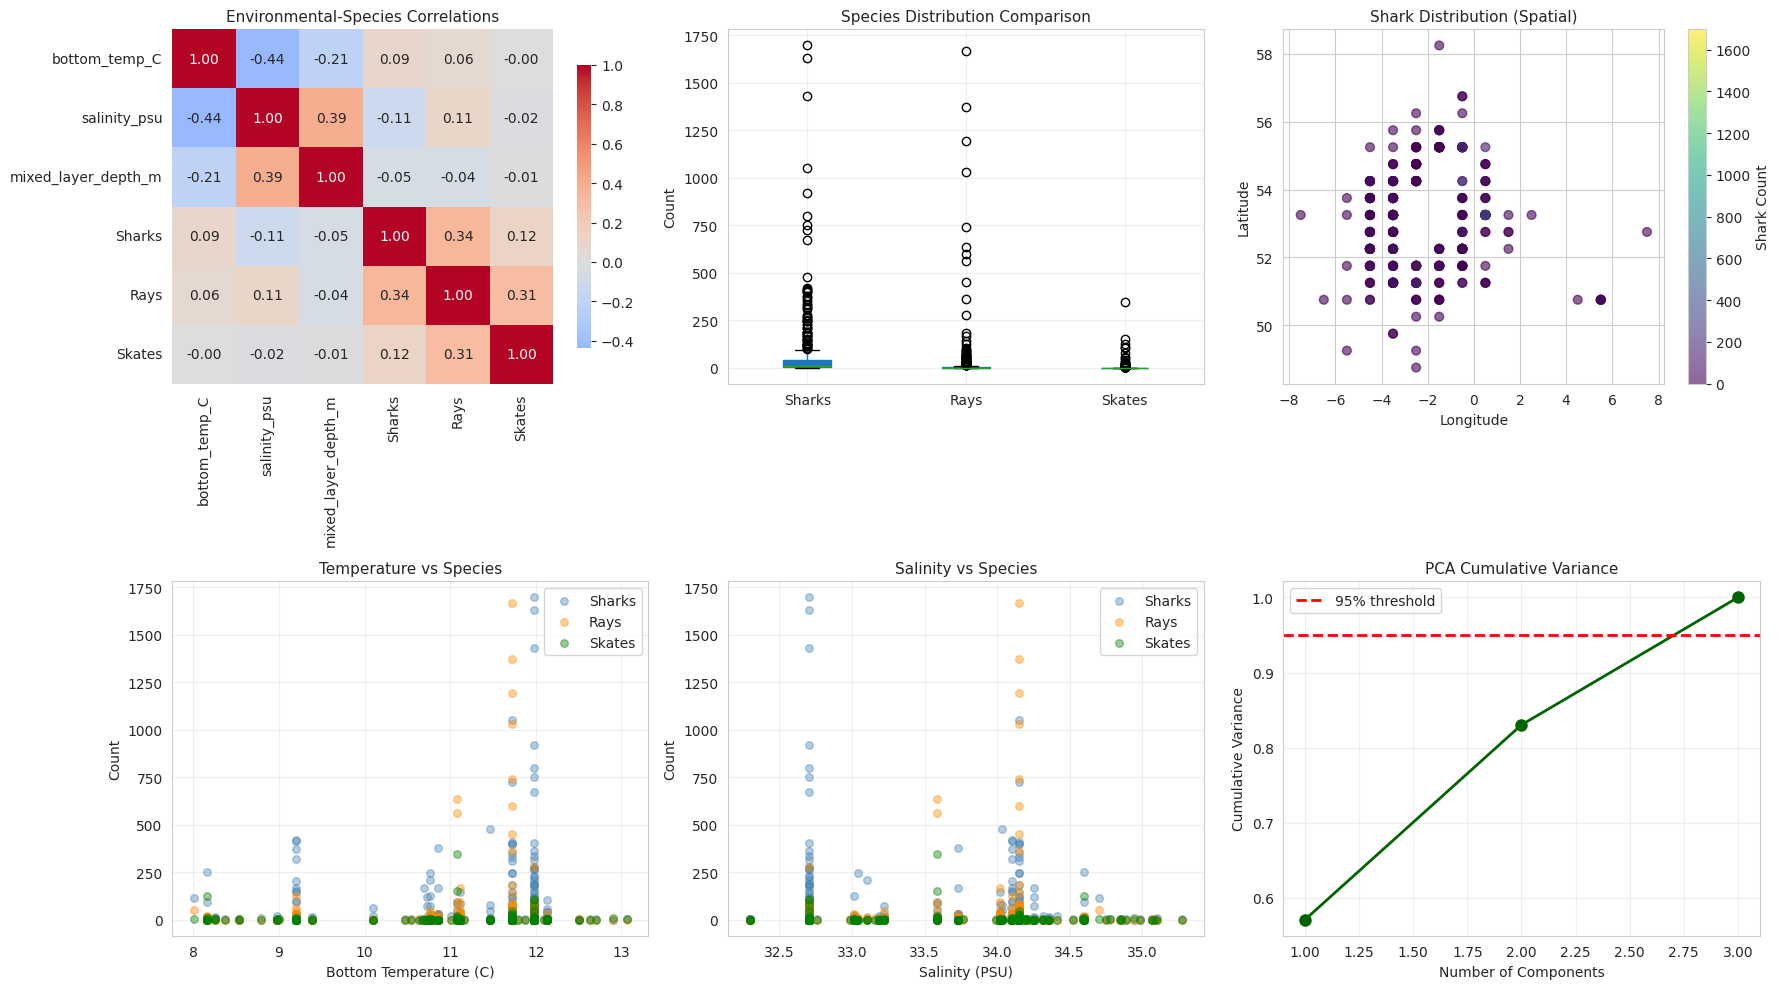

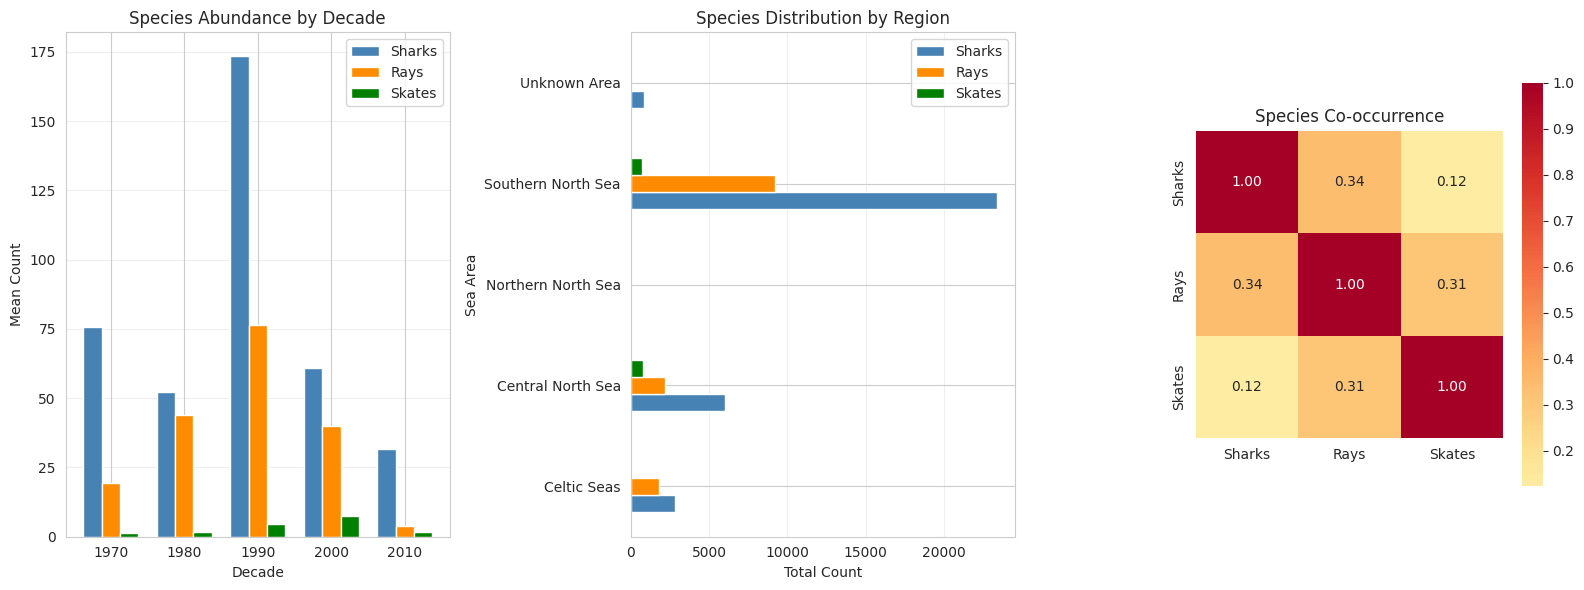

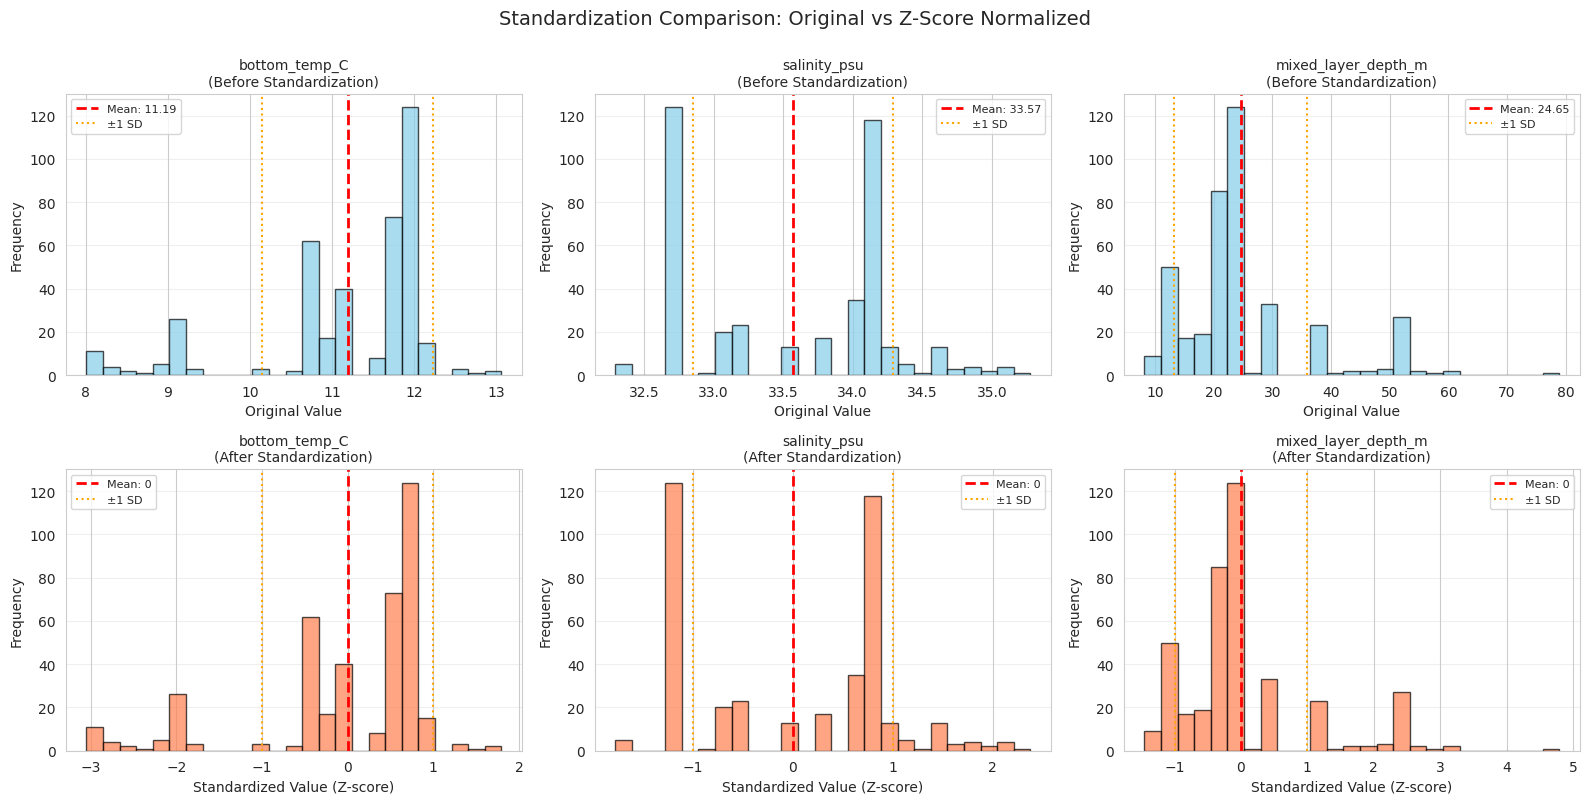

In [89]:
#Diagrams

sns.set_style("whitegrid")

fig1 = plt.figure(figsize=(18, 10))

ax = plt.subplot(2, 3, 1)
corr_data = pd.concat([X_train[env_cols], y_train_sharks, y_train_rays, y_train_skates], axis=1)
corr_data.columns = list(env_cols) + ['Sharks', 'Rays', 'Skates']
sns.heatmap(corr_data.corr(), annot=True, fmt='.2f', cmap='coolwarm', center=0, ax=ax, cbar_kws={'shrink': 0.8})
ax.set_title('Environmental-Species Correlations', fontsize=11)

ax = plt.subplot(2, 3, 2)
species_data = pd.DataFrame({
    'Sharks': y_train_sharks.values,
    'Rays': y_train_rays.values,
    'Skates': y_train_skates.values
})
species_data. boxplot(ax=ax, patch_artist=True)
ax. set_ylabel('Count')
ax.set_title('Species Distribution Comparison', fontsize=11)
ax.grid(True, alpha=0.3)

ax = plt.subplot(2, 3, 3)
ax.scatter(X_train['centroid_lon'], X_train['centroid_lat'],
           c=y_train_sharks, cmap='viridis', s=40, alpha=0.6)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Shark Distribution (Spatial)', fontsize=11)
cbar = plt.colorbar(ax.collections[0], ax=ax)
cbar.set_label('Shark Count')

ax = plt.subplot(2, 3, 4)
ax.scatter(X_train['bottom_temp_C'], y_train_sharks, alpha=0.4, s=30, color='steelblue', label='Sharks')
ax. scatter(X_train['bottom_temp_C'], y_train_rays, alpha=0.4, s=30, color='darkorange', label='Rays')
ax.scatter(X_train['bottom_temp_C'], y_train_skates, alpha=0.4, s=30, color='green', label='Skates')
ax.set_xlabel('Bottom Temperature (C)')
ax.set_ylabel('Count')
ax.set_title('Temperature vs Species', fontsize=11)
ax.legend()
ax.grid(True, alpha=0.3)

ax = plt.subplot(2, 3, 5)
ax. scatter(X_train['salinity_psu'], y_train_sharks, alpha=0.4, s=30, color='steelblue', label='Sharks')
ax.scatter(X_train['salinity_psu'], y_train_rays, alpha=0.4, s=30, color='darkorange', label='Rays')
ax.scatter(X_train['salinity_psu'], y_train_skates, alpha=0.4, s=30, color='green', label='Skates')
ax.set_xlabel('Salinity (PSU)')
ax.set_ylabel('Count')
ax. set_title('Salinity vs Species', fontsize=11)
ax. legend()
ax.grid(True, alpha=0.3)

ax = plt.subplot(2, 3, 6)
ax.plot(range(1, len(cumulative_variance) + 1), cumulative_variance,
        marker='o', color='darkgreen', linewidth=2, markersize=8)
ax.axhline(y=0.95, color='red', linestyle='--', linewidth=2, label='95% threshold')
ax.set_xlabel('Number of Components')
ax.set_ylabel('Cumulative Variance')
ax.set_title('PCA Cumulative Variance', fontsize=11)
ax. legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

fig2 = plt.figure(figsize=(16, 6))

ax = plt.subplot(1, 3, 1)
decade_sharks = X_train. groupby('Decade'). apply(lambda x: y_train_sharks.loc[x.index]. mean())
decade_rays = X_train.groupby('Decade'). apply(lambda x: y_train_rays.loc[x.index].mean())
decade_skates = X_train. groupby('Decade').apply(lambda x: y_train_skates.loc[x.index]. mean())
x_pos = np.arange(len(decade_sharks))
width = 0.25
ax.bar(x_pos - width, decade_sharks.values, width, label='Sharks', color='steelblue')
ax.bar(x_pos, decade_rays.values, width, label='Rays', color='darkorange')
ax.bar(x_pos + width, decade_skates. values, width, label='Skates', color='green')
ax.set_xlabel('Decade')
ax.set_ylabel('Mean Count')
ax.set_title('Species Abundance by Decade', fontsize=12)
ax.set_xticks(x_pos)
ax.set_xticklabels(decade_sharks. index)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

ax = plt.subplot(1, 3, 2)
sea_area_data = df_clean. groupby('sea_area'). agg({
    'Total_Sharks': 'sum',
    'Total_Rays': 'sum',
    'Total_Skates': 'sum'
})
sea_area_data. plot(kind='barh', ax=ax, color=['steelblue', 'darkorange', 'green'])
ax.set_xlabel('Total Count')
ax.set_ylabel('Sea Area')
ax.set_title('Species Distribution by Region', fontsize=12)
ax.legend(['Sharks', 'Rays', 'Skates'])
ax.grid(True, alpha=0.3, axis='x')

ax = plt.subplot(1, 3, 3)
species_corr = pd.DataFrame({
    'Sharks': y_train_sharks.values,
    'Rays': y_train_rays.values,
    'Skates': y_train_skates.values
})
species_corr_matrix = species_corr.corr()
sns.heatmap(species_corr_matrix, annot=True, fmt='.2f', cmap='RdYlBu_r',
            center=0, ax=ax, square=True, cbar_kws={'shrink': 0.8})
ax.set_title('Species Co-occurrence', fontsize=12)

plt.tight_layout()
plt.show()

fig3 = plt.figure(figsize=(16, 8))

for i, col in enumerate(env_cols):
    ax = plt. subplot(2, 3, i + 1)
    X_train[col].hist(bins=25, ax=ax, color='skyblue', edgecolor='black', alpha=0.7)
    ax.set_xlabel('Original Value')
    ax.set_ylabel('Frequency')
    ax.set_title(f'{col}\n(Before Standardization)', fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')

    mean_val = X_train[col].mean()
    std_val = X_train[col].std()
    ax. axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
    ax.axvline(mean_val - std_val, color='orange', linestyle=':', linewidth=1.5, label=f'±1 SD')
    ax.axvline(mean_val + std_val, color='orange', linestyle=':', linewidth=1.5)
    ax.legend(fontsize=8)

for i, col in enumerate(env_cols):
    ax = plt. subplot(2, 3, i + 4)
    X_train_scaled[col].hist(bins=25, ax=ax, color='coral', edgecolor='black', alpha=0.7)
    ax.set_xlabel('Standardized Value (Z-score)')
    ax.set_ylabel('Frequency')
    ax. set_title(f'{col}\n(After Standardization)', fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')
    ax.axvline(0, color='red', linestyle='--', linewidth=2, label='Mean: 0')
    ax.axvline(-1, color='orange', linestyle=':', linewidth=1.5, label='±1 SD')
    ax.axvline(1, color='orange', linestyle=':', linewidth=1.5)
    ax.legend(fontsize=8)

plt.suptitle('Standardization Comparison: Original vs Z-Score Normalized', fontsize=14, y=1.00)
plt.tight_layout()
plt.show()


In [90]:
#Updating ds
df_clean.to_csv('species_distribution_clean.csv', index=False)
df = pd.read_csv('species_distribution_clean.csv')
